In [1]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path
import multiprocessing

import numpy as np
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer.reparam import TransformReparam
from numpyro.distributions.transforms import AffineTransform, AbsTransform

from hbmep.config import Config
from hbmep.model import Baseline
from hbmep.model.utils import Site as site

from hbmep_paper.utils import simulate, run_experiment
from hbmep_paper.utils.constants import HBM

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()


In [2]:
root_path = Path(os.getcwd()).parent.parent.parent.absolute()
toml_path = os.path.join(root_path, "configs/experiments.toml")

config = Config(toml_path=toml_path)
config.BUILD_DIR = "/home/vishu/repos/hbmep-paper/reports/reparam-2/"


2023-08-07 12:42:53,612 - hbmep.config - INFO - Verifying configuration ...
2023-08-07 12:42:53,612 - hbmep.config - INFO - Success!


In [3]:

class HierarchicalBayesian(Baseline):
    LINK = HBM

    def __init__(self, config: Config):
        super(HierarchicalBayesian, self).__init__(config=config)

    def _model(self, subject, features, intensity, response_obs=None):
        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)

        n_data = intensity.shape[0]
        n_subject = np.unique(subject).shape[0]
        n_feature0 = np.unique(feature0).shape[0]

        priors_reparam_config = {
            var: TransformReparam() for var in [site.mu_a, site.sigma_a, site.sigma_b, site.sigma_L, site.sigma_H, site.sigma_v]
        }
        hyperpriors_reparam_config = {
            var: TransformReparam() for var in [site.a, site.b, site.L, site.H, site.v]
        }

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate(site.n_subject, n_subject, dim=-2):
                """ Hyper-priors """
                with numpyro.handlers.reparam(config=priors_reparam_config):
                    mu_a = numpyro.sample(
                        site.mu_a,
                        dist.TransformedDistribution(
                            dist.Normal(0, 1),
                            [AffineTransform(150, 50), AbsTransform()]
                        )
                    )
                    sigma_a = numpyro.sample(
                        site.sigma_a,
                        dist.TransformedDistribution(
                            dist.Normal(0, 1),
                            [AffineTransform(0, 50), AbsTransform()]
                        )
                    )

                    sigma_b = numpyro.sample(
                        site.sigma_b,
                        dist.TransformedDistribution(
                            dist.Normal(0, 1),
                            [AffineTransform(0, 0.1), AbsTransform()]
                        )
                    )

                    sigma_L = numpyro.sample(
                        site.sigma_L,
                        dist.TransformedDistribution(
                            dist.Normal(0, 1),
                            [AffineTransform(0, 0.05), AbsTransform()]
                        )
                    )
                    sigma_H = numpyro.sample(
                        site.sigma_H,
                        dist.TransformedDistribution(
                            dist.Normal(0, 1),
                            [AffineTransform(0, 5), AbsTransform()]
                        )
                    )
                    sigma_v = numpyro.sample(
                        site.sigma_v,
                        dist.TransformedDistribution(
                            dist.Normal(0, 1),
                            [AffineTransform(0, 10), AbsTransform()]
                        )
                    )

                # mu_a = numpyro.sample(
                #     site.mu_a,
                #     dist.TruncatedNormal(150, 50, low=0)
                # )
                # sigma_a = numpyro.sample(site.sigma_a, dist.HalfNormal(50))

                # sigma_b = numpyro.sample(site.sigma_b, dist.HalfNormal(0.1))

                # sigma_L = numpyro.sample(site.sigma_L, dist.HalfNormal(0.05))
                # sigma_H = numpyro.sample(site.sigma_H, dist.HalfNormal(5))
                # sigma_v = numpyro.sample(site.sigma_v, dist.HalfNormal(10))

                with numpyro.plate("n_feature0", n_feature0, dim=-3):
                    """ Priors """
                    with numpyro.handlers.reparam(config=hyperpriors_reparam_config):
                        a = numpyro.sample(
                            site.a,
                            dist.TransformedDistribution(
                                dist.Normal(0, 1),
                                [AffineTransform(mu_a, sigma_a), AbsTransform()]
                            )
                        )
                        b = numpyro.sample(
                            site.b,
                            dist.TransformedDistribution(
                                dist.Normal(0, 1),
                                [AffineTransform(0, sigma_b), AbsTransform()]
                            )
                        )

                        L = numpyro.sample(
                            site.L,
                            dist.TransformedDistribution(
                                dist.Normal(0, 1),
                                [AffineTransform(0, sigma_L), AbsTransform()]
                            )
                        )
                        H = numpyro.sample(
                            site.H,
                            dist.TransformedDistribution(
                                dist.Normal(0, 1),
                                [AffineTransform(0, sigma_H), AbsTransform()]
                            )
                        )
                        v = numpyro.sample(
                            site.v,
                            dist.TransformedDistribution(
                                dist.Normal(0, 1),
                                [AffineTransform(0, sigma_v), AbsTransform()]
                            )
                        )

                    g_1 = numpyro.sample(site.g_1, dist.Exponential(0.01))
                    g_2 = numpyro.sample(site.g_2, dist.Exponential(0.01))

        """ Model """
        mu = numpyro.deterministic(
            site.mu,
            L[feature0, subject]
            + jnp.maximum(
                0,
                -1
                + (H[feature0, subject] + 1)
                / jnp.power(
                    1
                    + (jnp.power(1 + H[feature0, subject], v[feature0, subject]) - 1)
                    * jnp.exp(-b[feature0, subject] * (intensity - a[feature0, subject])),
                    1 / v[feature0, subject]
                )
            )
        )
        beta = numpyro.deterministic(
            site.beta,
            g_1[feature0, subject] + g_2[feature0, subject] * (1 / mu)
        )

        """ Observation """
        with numpyro.plate(site.data, n_data):
            return numpyro.sample(
                site.obs,
                dist.Gamma(concentration=mu * beta, rate=beta).to_event(1),
                obs=response_obs
            )


In [4]:
from hbmep_paper.model import Simulator


simulator = Simulator(config=config)

simulation_params = {
    "n_subject": 3,
    "n_feature0": 2,
    "n_repeats": 10,
    "downsample_rate": 1
}
df, posterior_samples_true = simulate(model=simulator, **simulation_params)


2023-08-07 12:42:53,745 - hbmep.model.baseline - INFO - Initialized model with hierarchical_bayesian link
2023-08-07 12:42:53,745 - hbmep_paper.utils.utils - INFO - Simulating data ...


2023-08-07 12:42:57,189 - hbmep.utils.utils - INFO - func:predict took: 3.44 sec
2023-08-07 12:42:57,190 - hbmep.utils.utils - INFO - func:simulate took: 3.44 sec


In [5]:
model = HierarchicalBayesian(config=config)
df, encoder_dict = model.load(df=df)

obs = np.array(posterior_samples_true[site.obs])
df[model.response] = obs[0, ...]

2023-08-07 12:42:57,231 - hbmep.model.baseline - INFO - Initialized model with hierarchical_bayesian link
2023-08-07 12:42:57,231 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/reparam-2/
2023-08-07 12:42:57,232 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/reparam-2/
2023-08-07 12:42:57,232 - hbmep.dataset.core - INFO - Processing data ...
2023-08-07 12:42:57,234 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [6]:
mcmc, posterior_samples = model.run_inference(df=df)

2023-08-07 12:42:57,297 - hbmep.model.baseline - INFO - Running inference with hierarchical_bayesian ...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-08-07 13:00:21,604 - hbmep.utils.utils - INFO - func:run_inference took: 17 min and 24.31 sec


In [8]:
mcmc.print_summary(prob=.95)


                   mean       std    median      2.5%     97.5%     n_eff     r_hat
H_base[0,0,0]     -0.01      0.83     -0.00     -1.52      1.57     14.05      1.96
H_base[0,1,0]      0.23      0.78      0.52     -1.28      1.40     11.88      2.62
H_base[0,2,0]      0.29      1.09      0.57     -1.93      2.06     13.06      2.12
H_base[1,0,0]     -0.24      0.60     -0.32     -1.27      1.06     15.15      1.79
H_base[1,1,0]     -0.30      1.14     -0.75     -1.99      1.77     11.65      2.78
H_base[1,2,0]      0.14      1.10      0.32     -1.89      2.10     13.38      2.05
L_base[0,0,0]     -0.04      0.26     -0.11     -0.48      0.45     11.72      2.85
L_base[0,1,0]      0.07      1.26      0.57     -2.14      2.09     11.88      2.66
L_base[0,2,0]      0.03      0.12      0.03     -0.22      0.25     15.84      1.76
L_base[1,0,0]      0.08      1.45     -0.00     -2.29      2.76     11.65      2.90
L_base[1,1,0]     -0.09      0.48     -0.26     -0.87      0.75     11.97  

In [9]:
import arviz as az

numpyro_data = az.from_numpyro(mcmc)

az.summary(numpyro_data, var_names=[site.a, site.b, site.L, site.H, site.v])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"a[0, 0, 0]",128.712,1.792,125.342,131.833,0.016,0.011,14964.0,12181.0,1.00
"a[0, 1, 0]",218.224,0.704,216.873,219.473,0.009,0.006,6809.0,17505.0,1.00
"a[0, 2, 0]",264.665,0.310,264.074,265.215,0.003,0.002,14228.0,35810.0,1.00
"a[1, 0, 0]",136.533,0.732,135.275,137.974,0.008,0.006,8255.0,30537.0,1.00
"a[1, 1, 0]",187.668,0.062,187.551,187.782,0.000,0.000,47192.0,59785.0,1.00
"a[1, 2, 0]",247.240,0.104,247.045,247.432,0.000,0.000,81167.0,69544.0,1.00
"b[0, 0, 0]",0.018,0.012,0.004,0.040,0.000,0.000,517.0,1502.0,1.03
"b[0, 1, 0]",0.024,0.010,0.008,0.041,0.000,0.000,936.0,2884.0,1.02
"b[0, 2, 0]",0.072,0.052,0.008,0.167,0.002,0.001,736.0,1490.0,1.03
"b[1, 0, 0]",0.087,0.031,0.047,0.145,0.001,0.001,1302.0,3202.0,1.02


In [8]:
p = mcmc.get_samples(group_by_chain=True)


In [15]:
a = np.array(p[site.a])
a_base = np.array(p["a_base"])
g_1 = np.array(p[site.g_1])
g_2 = np.array(p[site.g_2])

In [13]:
a.shape

(4, 6000, 3, 2, 1)

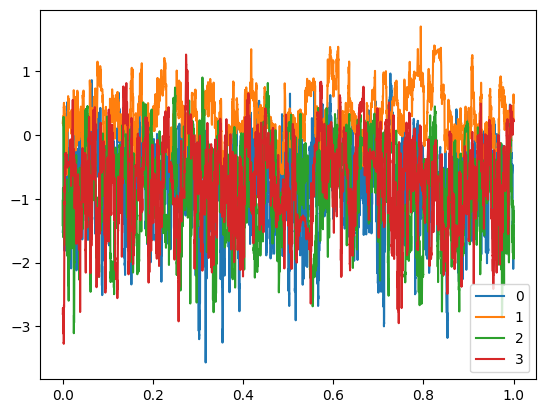

In [17]:
import seaborn as sns

y0, y1, y2 = 1, 0, 0
x = np.linspace(0, 1, 6000)
var = a_base

for i in range(4):
    sns.lineplot(x=x, y=var[i, :, y0, y1, y2], label=f"{i}")

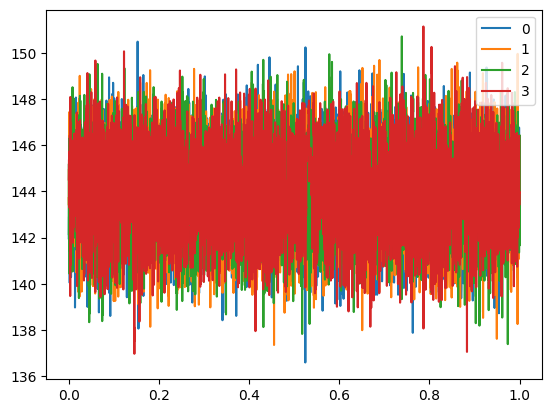

In [18]:
import seaborn as sns

x = np.linspace(0, 1, 6000)
var = a

for i in range(4):
    sns.lineplot(x=x, y=var[i, :, y0, y1, y2], label=f"{i}")

In [10]:
mcmc.print_summary(exclude_deterministic=False)


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     H[0,0,0]      0.42      0.22      0.39      0.29      0.55   2995.05      1.01
     H[0,1,0]      3.20      0.70      3.02      2.32      4.19    296.03      1.05
     H[0,2,0]      5.45      4.06      4.14      1.52     10.58   1700.69      1.01
     H[1,0,0]      0.31      0.01      0.31      0.30      0.32  10821.28      1.00
     H[1,1,0]      4.56      0.02      4.56      4.53      4.59  55943.58      1.00
     H[1,2,0]      5.37      4.34      4.07      0.79     10.76   1740.14      1.01
H_base[0,0,0]      0.05      0.83      0.16     -1.30      1.33     14.92      1.86
H_base[0,1,0]      0.21      0.78      0.50     -1.06      1.28     11.87      2.63
H_base[0,2,0]      0.32      1.10      0.56     -1.53      1.95     13.44      2.04
H_base[1,0,0]     -0.24      0.60     -0.28     -1.14      0.82     16.52      1.71
H_base[1,1,0]     -0.32      1.12     -0.72     -1.74      1.54     11.72  

In [11]:
a.shape

(4, 6000, 3, 2, 1)

In [5]:
model.render_recruitment_curves(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples)


2023-08-02 13:00:41,176 - hbmep.model.baseline - INFO - Generating predictions ...
2023-08-02 13:00:46,675 - hbmep.utils.utils - INFO - func:predict took: 5.50 sec
2023-08-02 13:00:46,698 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-08-02 13:00:48,720 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/reparam/recruitment_curves.pdf
2023-08-02 13:00:48,721 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 7.54 sec


In [6]:
model.render_predictive_check(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples)


2023-08-02 13:00:48,833 - hbmep.model.baseline - INFO - Generating predictions ...
2023-08-02 13:00:54,256 - hbmep.utils.utils - INFO - func:predict took: 5.42 sec
2023-08-02 13:00:54,293 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-08-02 13:00:57,665 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/reparam/posterior_predictive_check.pdf
2023-08-02 13:00:57,666 - hbmep.utils.utils - INFO - func:render_predictive_check took: 8.83 sec


In [8]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

posterior_samples_2 = mcmc.get_samples(group_by_chain=True)
a = np.array(posterior_samples_2["a"])
a_base = np.array(posterior_samples_2["a_base"])
µ_a = np.array(posterior_samples_2["µ_a"])
H = np.array(posterior_samples_2["H"])

In [ ]:
a_dict = {"a": posterior_samples_2["a"]}

In [11]:
var = ""

az.rhat(posterior_samples_2, var_names=[var])[var].to_numpy().max()

1.0049830437306058

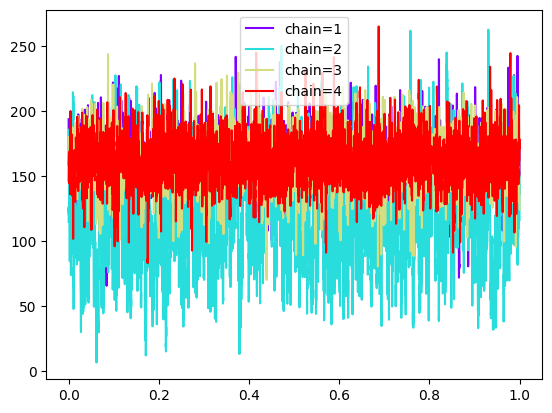

In [ ]:
p, q, r = 1,0,0

color = iter(plt.cm.rainbow(np.linspace(0, 1, 4)))
x = np.linspace(0, 1, 6000)

for i in range(4):
    c = next(color)
    # sns.lineplot(x=x, y=a_base[i, :, p, q, r], color=c, label=f"chain={i+1}")
    sns.lineplot(x=x, y=µ_a[i, :, 0, 0], color=c, label=f"chain={i+1}")

